Nama : Asep Saepul Rohman

Class : MC-25

ID : MC346D5Y2166

Emial : ejapten@gmail.com

# Import Library

In [1]:
import zipfile
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import keras
import tensorflow as tf
from skimage.util import img_as_ubyte

from skimage.util import img_as_float
from PIL import Image
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import InputLayer, Conv2D,  MaxPooling2D, MaxPool2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.notebook import tqdm as tq
from tensorflow.keras.preprocessing import image


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dta Preparation

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aseprohman","key":"3d100e30f218d3e9bc865efc5695185f"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download kaggle dataset and unzip the file

!kaggle datasets download -d lara311/flowers-five-classes
!unzip flowers-five-classes

Dataset URL: https://www.kaggle.com/datasets/lara311/flowers-five-classes
License(s): apache-2.0
Archive:  flowers-five-classes.zip
  inflating: train/daisy/10140303196_b88d3d6cec.jpg  
  inflating: train/daisy/10172379554_b296050f82_n.jpg  
  inflating: train/daisy/10172567486_2748826a8b.jpg  
  inflating: train/daisy/10172636503_21bededa75_n.jpg  
  inflating: train/daisy/10391248763_1d16681106_n.jpg  
  inflating: train/daisy/10437754174_22ec990b77_m.jpg  
  inflating: train/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: train/daisy/10437929963_bc13eebe0c.jpg  
  inflating: train/daisy/10466290366_cc72e33532.jpg  
  inflating: train/daisy/10466558316_a7198b87e2.jpg  
  inflating: train/daisy/10555749515_13a12a026e.jpg  
  inflating: train/daisy/10555815624_dc211569b0.jpg  
  inflating: train/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: train/daisy/10559679065_50d2b16f6d.jpg  
  inflating: train/daisy/10712722853_5632165b04.jpg  
  inflating: train/daisy/10770585085_4742b9dac

In [6]:
# mengganti nama folder
!mv /content/train /content/flowers

In [7]:
# membuat foler baru dan memindakannya agar terlihat rapi
base_path = 'flowers'
new_folder = os.path.join(base_path, 'type_flowers')

os.makedirs(new_folder, exist_ok=True)

# Pindahkan semua folder bunga ke folder type_flowers
for item in os.listdir(base_path):
    item_path = os.path.join(base_path, item)

    if os.path.isdir(item_path) and item != 'type_flowers':
        shutil.move(item_path, os.path.join(new_folder, item))

### Data Checking

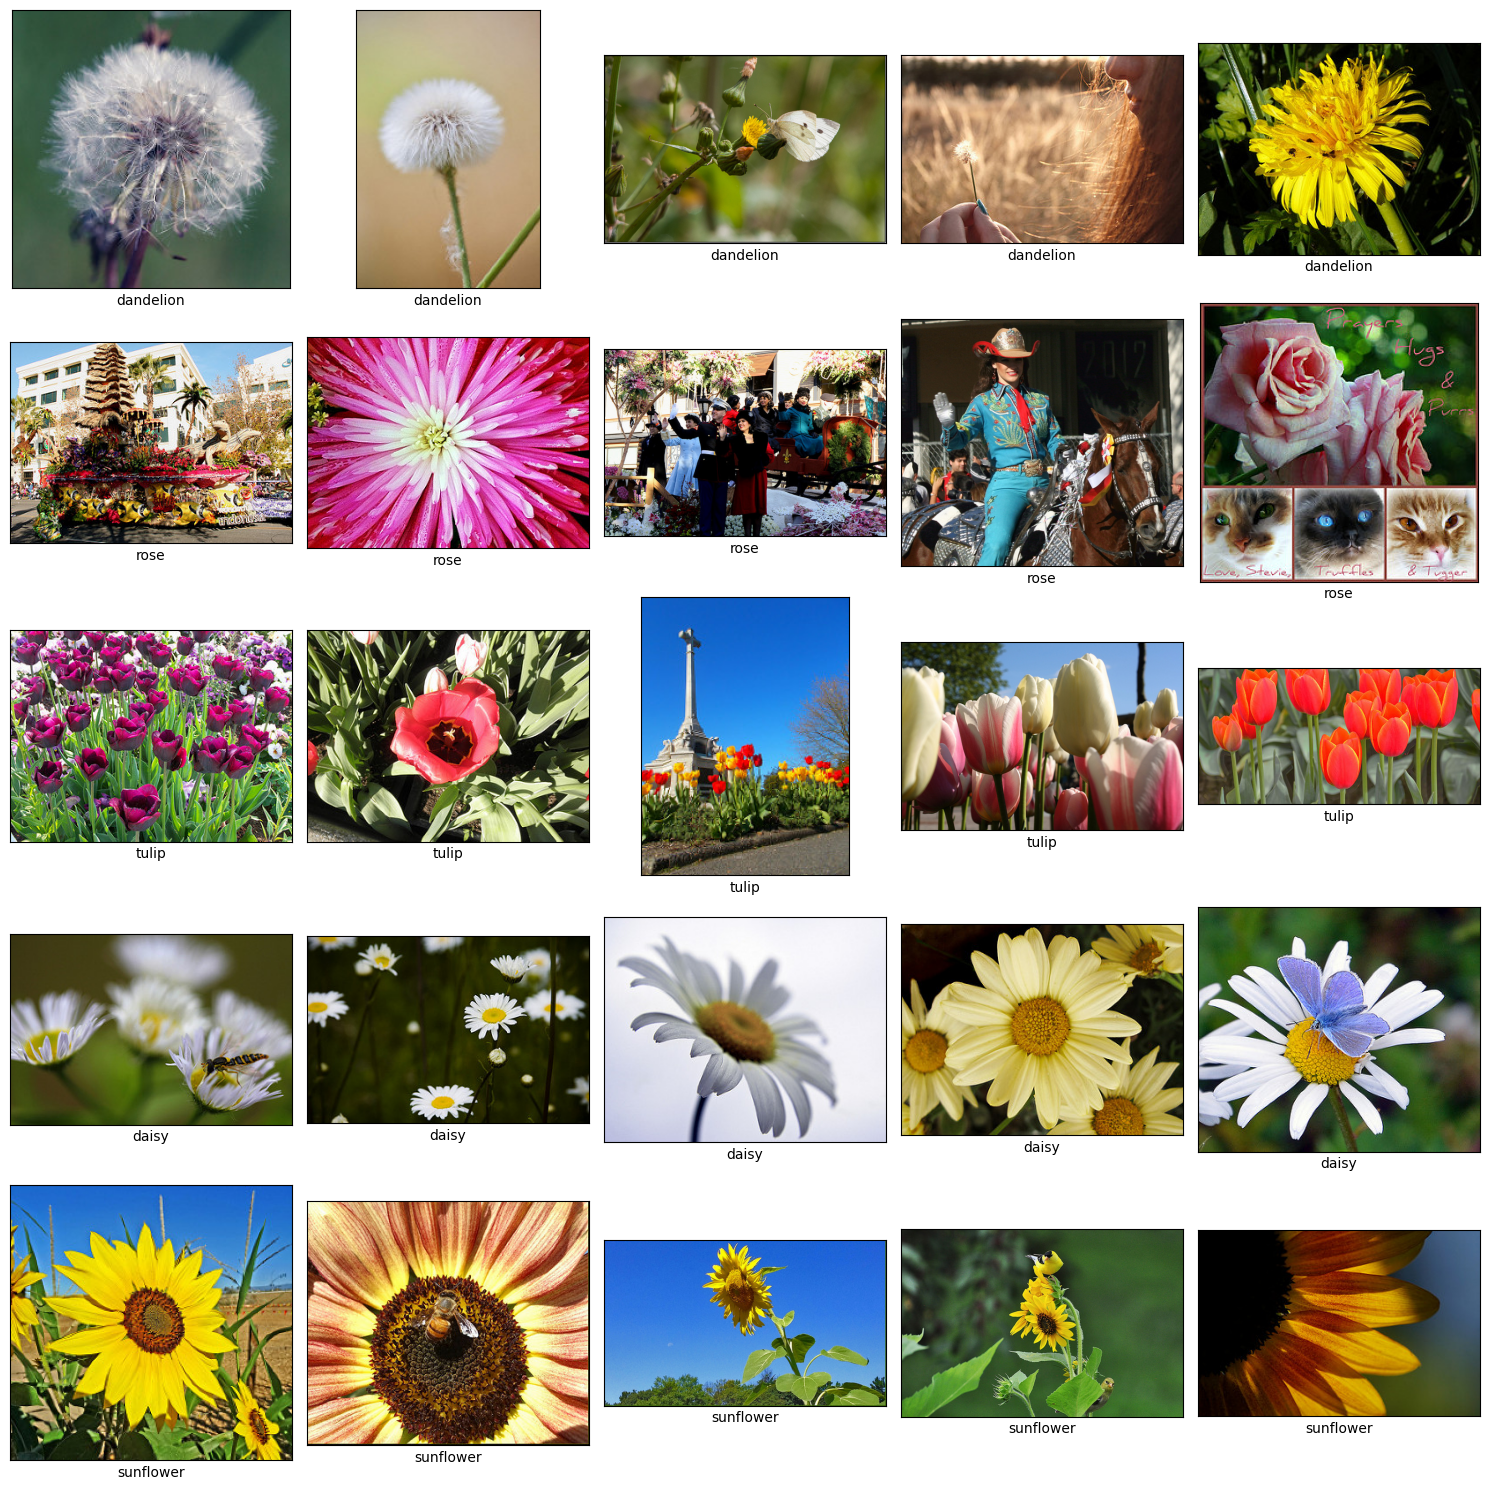

In [8]:
character_image = {}
path = "/content/flowers/type_flowers"
# Isi dictionary dengan gambar-gambar di setiap folder
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        character_image[class_name] = os.listdir(class_path)

# Memeriksa apakah dictionary telah terisi
if character_image:
    fig, axs = plt.subplots(len(character_image.keys()), 5, figsize=(15, 15))

    for i, class_name in enumerate(character_image.keys()):
        # Pilih 5 gambar acak dari setiap kelas
        images = np.random.choice(character_image[class_name], 5, replace=False)

        for j, image_name in enumerate(images):
            img_path = os.path.join(path, class_name, image_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

    fig.tight_layout()
else:
    print("Gambar tidak tersedia")

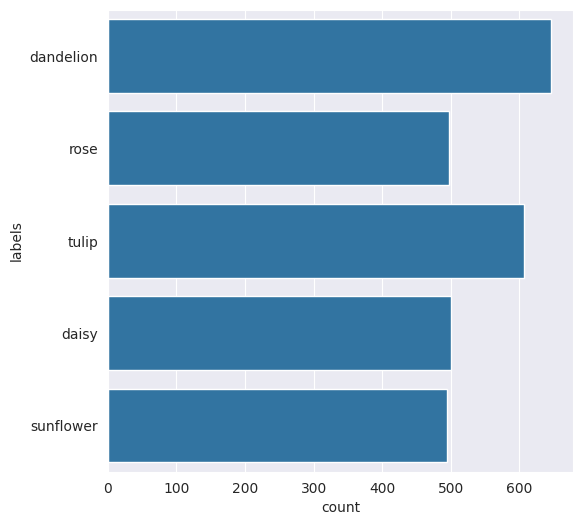

In [9]:
# Buat daftar nama untuk setiap file
file_name = []
label = []
full_path = []
# Telusuri file dari berbagai folder nya
for path, subdirs, files in os.walk(path):
    for name in files:
        full_path.append(os.path.join(path, name))
        label.append(path.split('/')[-1])
        file_name.append(name)

label_character = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":label})
# Plot distribusi gambar di setiap kelas
Label = label_character['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Split Data

In [10]:
# Mengetahui label dan jumlah nya
data_path = "/content/flowers/type_flowers"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(data_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
daisy        501
dandelion    646
rose         497
sunflower    495
tulip        607
dtype: int64

In [11]:
# Split Data
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# menyatkan ke dalam masing-masng dataframe
df_train = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_test = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

### Augmentasi Data

In [13]:
# Buat folder untk simpan hasil train dan untukk prroses augmentasi
train_folder = "/content/flowers/train_from_df"
os.makedirs(train_folder, exist_ok=True)

for idx, row in df_train.iterrows():
    label = row['labels']
    src = row['path']
    dst_folder = os.path.join(train_folder, label)
    os.makedirs(dst_folder, exist_ok=True)

    dst = os.path.join(dst_folder, os.path.basename(src))
    shutil.copy(src, dst)

In [14]:
# Buat Folder untuk simpan hasil augmentaasi
augmented_dir = "/content/flowers/train_augmented"
os.makedirs(augmented_dir, exist_ok=True)

In [15]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    angle = random.randint(0, 180)
    rotated = rotate(img, angle)
    return img_as_ubyte(rotated)

def clockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    angle = random.randint(0, 180)
    rotated = rotate(img, -angle)
    return img_as_ubyte(rotated)



# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def adjust_gamma(image, gamma=1.0, gain=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 * gain for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    transform = AffineTransform(shear=0.2)
    sheared_img = warp(img, transform, mode="wrap")
    return img_as_ubyte(sheared_img)

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    transform = AffineTransform(translation=(0, 40))
    warped = warp(img, transform, mode="wrap")
    return img_as_ubyte(warped)

# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : adjust_gamma,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

In [18]:
# path gambar pada train
images_path = "/content/flowers/train_from_df"
# path gambar yang sudah di augmentasi
augmented_path = "/content/flowers/train_augmented"


In [19]:
images_to_generate_per_class = 1000

for class_folder in os.listdir(images_path):
    class_folder_path = os.path.join(images_path, class_folder)

    if not os.path.isdir(class_folder_path) or class_folder == 'augmented':
        continue

    print(f"\nMemproses folder: {class_folder}")
    # Buat folder
    target_class_folder = os.path.join(augmented_path, class_folder)
    os.makedirs(target_class_folder, exist_ok=True)

    # Simpan gambar ke folder augmented
    for img_name in os.listdir(class_folder_path):
        if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            src = os.path.join(class_folder_path, img_name)
            dst = os.path.join(target_class_folder, img_name)
            shutil.copy(src, dst)
    images = [
        os.path.join(class_folder_path, img)
        for img in os.listdir(class_folder_path)
        if img.lower().endswith(('.jpg', '.png', '.jpeg'))
    ]

    if not images:
        print(f"    Tidak ada gambar di {class_folder}, skip.")
        continue

    i = 0
    while i < images_to_generate_per_class:
        image_path = random.choice(images)
        image = cv2.imread(image_path)

        if image is None:
            print(f"    Gagal baca gambar {image_path}, skip.")
            continue

        # Transformasi random
        transform_name = random.choice(list(transformations.keys()))
        transform_function = transformations[transform_name]
        transformed_image = transform_function(image)

        new_file_name = f"{class_folder}_aug_{i}_{transform_name}.jpg"
        save_path = os.path.join(target_class_folder, new_file_name)
        cv2.imwrite(save_path, transformed_image)

        i += 1

    print(f"    Berhasil augmentasi {i} gambar untuk {class_folder}")

print("\nSelesai augmentasi dan penggabungan semua folder!")


Memproses folder: dandelion
    Berhasil augmentasi 1000 gambar untuk dandelion

Memproses folder: rose
    Berhasil augmentasi 1000 gambar untuk rose

Memproses folder: tulip
    Berhasil augmentasi 1000 gambar untuk tulip

Memproses folder: daisy
    Berhasil augmentasi 1000 gambar untuk daisy

Memproses folder: sunflower
    Berhasil augmentasi 1000 gambar untuk sunflower

Selesai augmentasi dan penggabungan semua folder!


In [20]:
#path data train hasil augmentasi
augmented_path = '/content/flowers/train_augmented'

data = []

# Loop semua subfolder
for label in os.listdir(augmented_path):
    label_path = os.path.join(augmented_path, label)

    if not os.path.isdir(label_path):
        continue

    # Loop semua file gambar dalam folder class
    for img_file in os.listdir(label_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(label_path, img_file)
            data.append({
                'path': full_path,
                'labels': label,
                'set': 'train'
            })

# Buat DataFrame
df_train_augmented = pd.DataFrame(data)
df_train_augmented

path     labels    set
0     /content/flowers/train_augmented/dandelion/141...  dandelion  train
1     /content/flowers/train_augmented/dandelion/180...  dandelion  train
2     /content/flowers/train_augmented/dandelion/136...  dandelion  train
3     /content/flowers/train_augmented/dandelion/699...  dandelion  train
4     /content/flowers/train_augmented/dandelion/dan...  dandelion  train
...                                                 ...        ...    ...
7191  /content/flowers/train_augmented/sunflower/151...  sunflower  train
7192  /content/flowers/train_augmented/sunflower/924...  sunflower  train
7193  /content/flowers/train_augmented/sunflower/sun...  sunflower  train
7194  /content/flowers/train_augmented/sunflower/sun...  sunflower  train
7195  /content/flowers/train_augmented/sunflower/sun...  sunflower  train

[7196 rows x 3 columns]

In [21]:
# Gabungkan datframe trai dan test
df_all = pd.concat([df_train_augmented, df_test], ignore_index=True)
# melihat nilai pada setiap label
print(df_all.groupby(['set', 'labels']).size(), '\n')

set    labels   
test   daisy         108
       dandelion     136
       rose           92
       sunflower      90
       tulip         124
train  daisy        1393
       dandelion    1510
       rose         1405
       sunflower    1405
       tulip        1483
dtype: int64 



In [25]:
# Simpan ke df dan dataset baru
base_path = "/content/flowers/flowers_final"

# Buat folder utama
os.makedirs(base_path, exist_ok=True)

# Loop semua baris di df_all
for idx, row in df_all.iterrows():
    label = row['labels']
    split = row['set']  # 'train' atau 'test'
    image_path = row['path']

    # Buat path tujuan
    dest_dir = os.path.join(base_path, split, label)
    os.makedirs(dest_dir, exist_ok=True)

    # Nama file (ambil nama file saja, bukan path lengkap)
    file_name = os.path.basename(image_path)
    dest_path = os.path.join(dest_dir, file_name)

    # Salin file ke folder tujuan
    shutil.copy(image_path, dest_path)

print("Semua data berhasil dipindah ke folder 'flowers_final'.")

Semua data berhasil dipindah ke folder 'flowers_final'.


### Normalisasi Data

In [27]:
train_data = "/content/flowers/flowers_final/train"
test_data = "/content/flowers/flowers_final/test"

In [74]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [75]:
train_generator = datagen.flow_from_directory(train_data,
                                              batch_size=32,
                                              target_size=(150, 150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)
validation_generator = datagen.flow_from_directory(train_data,
                                                   batch_size=32,
                                                   target_size=(150, 150),
                                                color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(test_data,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 6478 images belonging to 5 classes.
Found 718 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


# Modeling


In [76]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150,150,3))
base_model.trainable = False

<ipython-input-76-03c2e2fe4256>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150,150,3))


In [77]:
# pretrained Transfer Learning
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150,150,3))
base_model.trainable = False

#model
model_1 = Sequential([
    Input(shape=(150, 150, 3)),base_model,
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    # Global Average Pooling dan FC layer
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()


<ipython-input-77-11558c560b17>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150,150,3))


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,093 (10.03 MB)

 Trainable params: 371,109 (1.42 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [79]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_ckpt = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [early_stop, model_ckpt]

In [80]:
train_model = model_1.fit(train_generator,
          epochs=20,
          validation_data=validation_generator,
          callbacks=callbacks)

Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.4671 - loss: 1.4347
Epoch 1: val_loss improved from inf to 0.45549, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 159s 741ms/step - accuracy: 0.4677 - loss: 1.4328 - val_accuracy: 0.8315 - val_loss: 0.4555
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.8012 - loss: 0.5730
Epoch 2: val_loss improved from 0.45549 to 0.38400, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 150s 740ms/step - accuracy: 0.8013 - loss: 0.5728 - val_accuracy: 0.8760 - val_loss: 0.3840
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.8798 - loss: 0.3691
Epoch 3: val_loss improved from 0.38400 to 0.36028, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 156s 769ms/step - accuracy: 0.8797 - loss: 0.3691 - val_accuracy: 0.8663 - val_loss: 0.3603
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9007 - loss: 0.2881
Epoch 4: val_loss did not improve from 0.36028
203/203 ━━━━━━━━━━━━━━━━━━━━ 148s 732ms/step - accuracy: 0.9008 - loss: 0.2880 - val_accuracy: 0.8607 - val_loss: 0.4594
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9121 - loss: 0.2597
Epoch 5: val_loss did not improve from 0.36028
203/203 ━━━━━━━━━━━━━━━━━━━━ 148s 731ms/step - accuracy: 0.9122 - loss: 0.2595 - val_accuracy: 0.8928 - val_loss: 0.3970
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9489 - loss: 0.1561
Epoch 6: val_loss did not improve from 0.36028
203/203 ━━━━━━━━━━━━━━━━━━━━ 148s 730ms/step - accuracy: 0.9489 - loss: 0.1561 - val_accuracy: 0.9039 - val_loss: 0.4373
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.9638 - loss: 0.1175
Epoch 7: val_loss did n

# Evaluasi

In [81]:
# Evaluasi model
results = model_1.evaluate(test_generator, return_dict=True)

# Tampilkan hasil metrik dengan format rapi
print("\nHasil Evaluasi pada Data Test:")
print("==================================")
print(f"Loss: {results['loss']:.4f}")
print(f"Akurasi: {results['accuracy']*100:.2f}%")
# print("Precision Test: {:.2f}%".format(test_results[2] * 100))
# print("Recall Test: {:.2f}%".format(test_results[3] * 100))

print("==================================")

550/550 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.8603 - loss: 0.4605

Hasil Evaluasi pada Data Test:
Loss: 0.4635
Akurasi: 86.73%


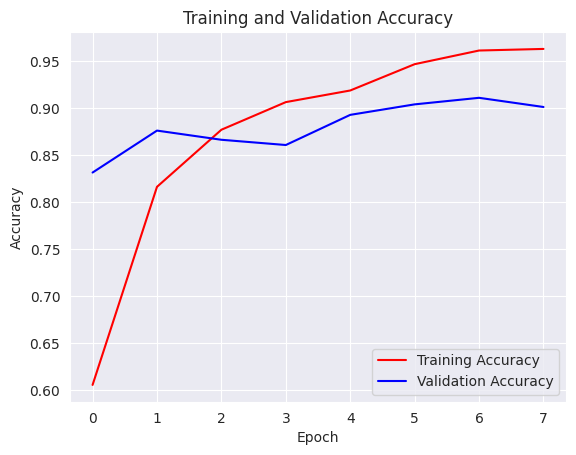

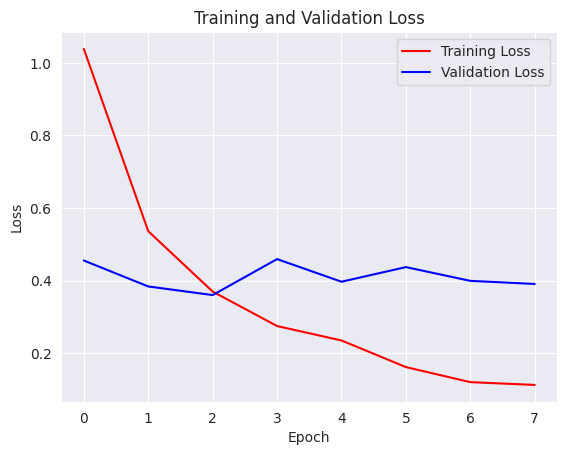

In [82]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs = range(len(acc))

# untuk akurasi
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Untuk loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Konversi

In [83]:
os.makedirs("submission/tfjs_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/saved_model", exist_ok=True)

In [84]:
# SavedModel
model_1.export("submission/saved_model/")

Saved artifact at 'submission/saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_2220')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140632779169360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779169936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779170320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779170128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779165136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779171472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779171856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779172240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779172048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779168976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14

In [85]:
# tflite

converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)
labels = ["cheetah", "leopard", "lion", "tiger"]
with open("submission/tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

Saved artifact at '/tmp/tmp2i4m3rqe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_2220')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140632779169360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779169936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779170320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779170128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779165136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779171472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779171856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779172240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779172048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779168976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140632779

In [92]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [94]:
# tfjs
!tensorflowjs_converter --input_format keras model_1.h5 ./model_tfjs

2025-05-04 16:48:04.372981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746377284.446755   62110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746377284.471320   62110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [87]:
from google.colab import files
import os
folder_path = '/content/submission'

for root, dirs, files_in_dir in os.walk(folder_path):
    for file in files_in_dir:
        file_path = os.path.join(root, file)
        files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [95]:
!pip freeze > requirements.txt

In [96]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>